In [1]:
# First we need to import some packages
import keras
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import json
from copy import deepcopy
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras.wrappers.scikit_learn import KerasClassifier
from keras.metrics import categorical_accuracy

# Now read in the data
data=pd.read_csv('./tmdb_5000_movies.csv')

# Change data and get only what we want
data=deepcopy(data[['title','genres','overview']])

# Print out the first record
print("Data before cleaning: ")
print("Title:", data['title'][0])
print("Genres:", data['genres'][0])
print("Overview:", data['overview'][0], "\n\n")

# define a function to clean our genres from [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]
# to [Action, Aventure, Fantasy, Science Fiction]
def clean_genres(genre_data):
    # List to hold results
    genre_list = []
    for item in genre_data:
        # Since data is json we can use the json lib
        json_data = json.loads(item)
        temp_list = []

        for dict_item in json_data:
            # Grab only the genre names
            temp_list.append(dict_item["name"])
    
        genre_list.append(temp_list)

    return genre_list

def clean_overview(overview_list):
    # List of words to remove
    words_to_remove = ["a", "and", "the", "but", "nor", "else", "or", "its", "it's", "of", "to", "in", "on", "is", "be",
                        "he", "his", "him" "she", "her", "an", "as", "for", "by", "are", "if", "it",
                        "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t",
                        "u", "v", "w", "x", "y", "z", "there", "their", "they're", "where", "wear", "were", "this", "that"
                      ]

    # List to hold results
    clean_overview_list = []
    for item in overview_list:
        # force item to be treated as a string
        item =str(item)
        
        # Split into a list of words
        words_list = item.split()
        
        temp_list = []
        # Remove any punctuation
        for word in words_list:
            # force item to be treated as a string, but first check if it is not empty
            if word:
                word = str(word)
                word = word.replace(",", "")
                word = word.replace(".", "")
                word = word.replace("\"", "")
                word = word.replace("-", "")
                word = word.replace(")", "")
                word = word.replace("(", "")
                word = word.replace("?", "")
                word = word.replace("!", "")
                word = word.replace("~", "")
                word = word.replace("`", "")
                word = word.replace("'", "")
                word = word.replace("’", "")
                word = word.replace(";", "")
                word = word.replace(":", "")
                word = word.replace("…", "")
                word = word.replace("−", "")
                temp_list.append(word)
        
        words_list = temp_list

        # Create a new list of filtered words
        filtered_words_list = [word for word in words_list if word.lower() not in words_to_remove]
        
        clean_overview_list.append(filtered_words_list)

    return clean_overview_list

data["genres"] = clean_genres(data["genres"])
data["overview"] = clean_overview(data["overview"])

# Print out the first record again
print("Data after cleaning: ")
print("Title:", data['title'][0])
print("Genres:", data['genres'][0])
print("Overview:", data['overview'][0], "\n\n")

Data before cleaning: 
Title: Avatar
Genres: [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]
Overview: In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. 


Data after cleaning: 
Title: Avatar
Genres: ['Action', 'Adventure', 'Fantasy', 'Science Fiction']
Overview: ['22nd', 'century', 'paraplegic', 'Marine', 'dispatched', 'moon', 'Pandora', 'unique', 'mission', 'becomes', 'torn', 'between', 'following', 'orders', 'protecting', 'alien', 'civilization'] 




In [2]:
# Next we use the Tokenizer from Keras to make our life easier. It will tokenize the text and encode (vectorize) it.
# But first let's copy our data

data_copy = deepcopy(data)

# Make one for each
overview_tokenizer = Tokenizer()
genre_tokenizer = Tokenizer()

# Feed tokenizers the data
overview_tokenizer.fit_on_texts(data_copy["overview"])
genre_tokenizer.fit_on_texts(data_copy["genres"])

# Show what the tokenizers found.
print("Overview word count:", overview_tokenizer.word_counts, "\n\n")
print("Genre word count:", genre_tokenizer.word_counts, "\n\n")
print("Overview unique word count:", len(overview_tokenizer.word_counts))
print("Genre unique word count:", len(genre_tokenizer.word_counts), "\n\n")

# Show how genre/overview are index
print("Overview index values:", overview_tokenizer.word_index, "\n\n")
print("Genre index values:", genre_tokenizer.word_index, "\n\n")

Overview word count: OrderedDict([('22nd', 4), ('century', 73), ('paraplegic', 1), ('marine', 14), ('dispatched', 9), ('moon', 16), ('pandora', 1), ('unique', 25), ('mission', 151), ('becomes', 263), ('torn', 23), ('between', 221), ('following', 51), ('orders', 20), ('protecting', 13), ('alien', 67), ('civilization', 10), ('captain', 61), ('barbossa', 1), ('long', 81), ('believed', 13), ('dead', 118), ('has', 949), ('come', 146), ('back', 313), ('life', 799), ('headed', 15), ('edge', 9), ('earth', 137), ('with', 2533), ('will', 416), ('turner', 10), ('elizabeth', 25), ('swann', 1), ('nothing', 71), ('quite', 18), ('seems', 91), ('cryptic', 4), ('message', 10), ('from', 1325), ('bonds', 10), ('past', 151), ('sends', 34), ('him', 815), ('trail', 28), ('uncover', 45), ('sinister', 30), ('organization', 34), ('while', 323), ('battles', 15), ('political', 47), ('forces', 124), ('keep', 104), ('secret', 175), ('service', 39), ('alive', 55), ('bond', 72), ('peels', 1), ('layers', 2), ('deceit

In [3]:
# Now we encode the genres and overview to create a matrix
encoded_overview = overview_tokenizer.texts_to_matrix(data_copy["overview"], mode="count")
encoded_genre = genre_tokenizer.texts_to_matrix(data_copy["genres"], mode="count")

print("Encoded overview data set:", encoded_overview, "\n\n")
print("Encoded genre data set:", encoded_genre, "\n\n")
print("Encoded overview data width:", len(encoded_overview[0]))
print("Encoded overview data height:", len(encoded_overview))
print("Encoded genre data width:", len(encoded_genre[0]))
print("Encoded genre data height:", len(encoded_genre), "\n\n")


Encoded overview data set: [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]] 


Encoded genre data set: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 


Encoded overview data width: 23662
Encoded overview data height: 4803
Encoded genre data width: 21
Encoded genre data height: 4803 




In [4]:
# Our data is now ready :)... I think.
print("Sample Data:", data_copy["title"][0], data_copy["genres"][0], data_copy["overview"][0])
print("Sample Data Encoded:", data_copy["title"][0], encoded_genre[0], encoded_overview[0], "\n\n")

Sample Data: Avatar ['Action', 'Adventure', 'Fantasy', 'Science Fiction'] ['22nd', 'century', 'paraplegic', 'Marine', 'dispatched', 'moon', 'Pandora', 'unique', 'mission', 'becomes', 'torn', 'between', 'following', 'orders', 'protecting', 'alien', 'civilization']
Sample Data Encoded: Avatar [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] 




In [5]:
# Now we assign stuff back to our data pandaframe and delete data_copy

# Here we append to and assign to our data pandaframe
data["genres"] = data_copy["genres"]
data["overview"] = data_copy["overview"]
data["title"] = data_copy["title"]
data["one_hot_genre"] = list(encoded_genre)
data["one_hot_overview"] = list(encoded_overview)
data = data.append({"genre_word_index": genre_tokenizer.word_index}, ignore_index=True)
data = data.append({"overview_word_index": overview_tokenizer.word_index}, ignore_index=True)
del data_copy

# Lastly Print our updated data pandaframe
print(data)

                                         title  \
0                                       Avatar   
1     Pirates of the Caribbean: At World's End   
2                                      Spectre   
3                        The Dark Knight Rises   
4                                  John Carter   
...                                        ...   
4800                 Signed, Sealed, Delivered   
4801                          Shanghai Calling   
4802                         My Date with Drew   
4803                                       NaN   
4804                                       NaN   

                                             genres  \
0     [Action, Adventure, Fantasy, Science Fiction]   
1                      [Adventure, Fantasy, Action]   
2                        [Action, Adventure, Crime]   
3                  [Action, Crime, Drama, Thriller]   
4              [Action, Adventure, Science Fiction]   
...                                             ...   
4800          

In [6]:
# Cool, now we can begin to build our nerual network, but first we need x_train, x_test, y_train, y_test
(X_train, X_test, y_train, y_test) = train_test_split(encoded_overview, encoded_genre, test_size=0.20)
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape, "X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

# Make the NN (Modified version from HW2)
def create_NN(hidden_layers = [1000], act = 'relu', opt = 'rmsprop', in_dim=X_train.shape[1], out_dim=y_train.shape[1]): 
    '''create a deep feedforwad neural network using keras
    
    Parameters
    -----------
    hidden_layers: a list that defines the numbers of hidden nodes for all hidden layers, e.g., [1000] indicates
    the nn has only one hidden layer with 1000 nodes, while [1000, 500] defines two hidden layers and the first
    layer has 1000 nodes and the second has 500 nodes.
    act: activation function for all hidden layers
    opt: optimizer
    
    Returns
    -------
    myNN: the neural network model
    
    ''' 
    myNN = keras.models.Sequential()
    
    
    num_hidden_layers = 0
    for layer in hidden_layers:
        num_hidden_layers = num_hidden_layers + 1 
        print("Hidden Layer:", num_hidden_layers, "Size of:", layer)
        #2.1 build all hidden layers
        myNN.add(keras.layers.Dense(
        units=layer,
        input_dim=in_dim,
        activation=act))

    # build the output layer and use sigmoid, https://stackoverflow.com/questions/44164749/how-does-keras-handle-multilabel-classification
    myNN.add(keras.layers.Dense(
    units=out_dim,
    activation='sigmoid'))

    #2.3 choose the optimizer, compile the network and return it. Use 'accuracy' as the metrics
    myNN.compile(optimizer=opt, loss='binary_crossentropy', metrics=[categorical_accuracy])
    return myNN
    
h_nodes = [1000, 500] # two hidden layers with 1000 and 500 nodes, respectively.
myNN = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN.summary()

myNN2 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN3 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
# Note to self and others. This took about ~30 for my machine to complete
history1 = myNN.fit(X_train, y_train, epochs=5, batch_size=2000, verbose=2)
history2 = myNN2.fit(X_train, y_train, epochs=50, batch_size=2000, verbose=2)
history3 = myNN3.fit(X_train, y_train, epochs=500, batch_size=2000, verbose=2)

X_train shape: (3842, 23662) y_train shape: (3842, 21) X_test shape: (961, 23662) y_test shape: (961, 21)
Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              23663000  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 21)                10521     
Total params: 24,174,021
Trainable params: 24,174,021
Non-trainable params: 0
_________________________________________________________________
Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/5
2/2 - 5s - loss: 0.6705 - categorical_accuracy: 0.3103
Epoch 2/5
2/2 - 3s - loss:

Epoch 53/500
2/2 - 3s - loss: 0.0021 - categorical_accuracy: 0.6999
Epoch 54/500
2/2 - 3s - loss: 0.0020 - categorical_accuracy: 0.6996
Epoch 55/500
2/2 - 4s - loss: 0.0019 - categorical_accuracy: 0.6996
Epoch 56/500
2/2 - 3s - loss: 0.0018 - categorical_accuracy: 0.6983
Epoch 57/500
2/2 - 3s - loss: 0.0017 - categorical_accuracy: 0.6986
Epoch 58/500
2/2 - 3s - loss: 0.0017 - categorical_accuracy: 0.7002
Epoch 59/500
2/2 - 3s - loss: 0.0016 - categorical_accuracy: 0.7002
Epoch 60/500
2/2 - 4s - loss: 0.0016 - categorical_accuracy: 0.6994
Epoch 61/500
2/2 - 3s - loss: 0.0015 - categorical_accuracy: 0.6996
Epoch 62/500
2/2 - 3s - loss: 0.0014 - categorical_accuracy: 0.6994
Epoch 63/500
2/2 - 3s - loss: 0.0014 - categorical_accuracy: 0.7002
Epoch 64/500
2/2 - 3s - loss: 0.0013 - categorical_accuracy: 0.7002
Epoch 65/500
2/2 - 5s - loss: 0.0013 - categorical_accuracy: 0.7007
Epoch 66/500
2/2 - 3s - loss: 0.0013 - categorical_accuracy: 0.7002
Epoch 67/500
2/2 - 4s - loss: 0.0012 - categoric

2/2 - 3s - loss: 2.7329e-04 - categorical_accuracy: 0.6921
Epoch 168/500
2/2 - 3s - loss: 2.7133e-04 - categorical_accuracy: 0.6936
Epoch 169/500
2/2 - 3s - loss: 2.6924e-04 - categorical_accuracy: 0.6934
Epoch 170/500
2/2 - 3s - loss: 2.6757e-04 - categorical_accuracy: 0.6923
Epoch 171/500
2/2 - 3s - loss: 2.6515e-04 - categorical_accuracy: 0.6916
Epoch 172/500
2/2 - 3s - loss: 2.6340e-04 - categorical_accuracy: 0.6913
Epoch 173/500
2/2 - 3s - loss: 2.6134e-04 - categorical_accuracy: 0.6900
Epoch 174/500
2/2 - 3s - loss: 2.5940e-04 - categorical_accuracy: 0.6897
Epoch 175/500
2/2 - 3s - loss: 2.5796e-04 - categorical_accuracy: 0.6905
Epoch 176/500
2/2 - 3s - loss: 2.5575e-04 - categorical_accuracy: 0.6908
Epoch 177/500
2/2 - 3s - loss: 2.5414e-04 - categorical_accuracy: 0.6905
Epoch 178/500
2/2 - 3s - loss: 2.5252e-04 - categorical_accuracy: 0.6897
Epoch 179/500
2/2 - 3s - loss: 2.5049e-04 - categorical_accuracy: 0.6895
Epoch 180/500
2/2 - 3s - loss: 2.4859e-04 - categorical_accuracy:

Epoch 280/500
2/2 - 3s - loss: 1.4743e-04 - categorical_accuracy: 0.6773
Epoch 281/500
2/2 - 3s - loss: 1.4629e-04 - categorical_accuracy: 0.6767
Epoch 282/500
2/2 - 3s - loss: 1.4554e-04 - categorical_accuracy: 0.6767
Epoch 283/500
2/2 - 3s - loss: 1.4524e-04 - categorical_accuracy: 0.6749
Epoch 284/500
2/2 - 3s - loss: 1.4472e-04 - categorical_accuracy: 0.6749
Epoch 285/500
2/2 - 3s - loss: 1.4381e-04 - categorical_accuracy: 0.6757
Epoch 286/500
2/2 - 3s - loss: 1.4342e-04 - categorical_accuracy: 0.6739
Epoch 287/500
2/2 - 3s - loss: 1.4268e-04 - categorical_accuracy: 0.6718
Epoch 288/500
2/2 - 3s - loss: 1.4217e-04 - categorical_accuracy: 0.6723
Epoch 289/500
2/2 - 3s - loss: 1.4188e-04 - categorical_accuracy: 0.6749
Epoch 290/500
2/2 - 3s - loss: 1.4092e-04 - categorical_accuracy: 0.6780
Epoch 291/500
2/2 - 3s - loss: 1.4021e-04 - categorical_accuracy: 0.6780
Epoch 292/500
2/2 - 3s - loss: 1.3973e-04 - categorical_accuracy: 0.6783
Epoch 293/500
2/2 - 4s - loss: 1.3914e-04 - categor

Epoch 393/500
2/2 - 3s - loss: 9.7767e-05 - categorical_accuracy: 0.6679
Epoch 394/500
2/2 - 4s - loss: 9.7351e-05 - categorical_accuracy: 0.6676
Epoch 395/500
2/2 - 3s - loss: 9.7190e-05 - categorical_accuracy: 0.6679
Epoch 396/500
2/2 - 3s - loss: 9.6877e-05 - categorical_accuracy: 0.6658
Epoch 397/500
2/2 - 3s - loss: 9.6739e-05 - categorical_accuracy: 0.6653
Epoch 398/500
2/2 - 3s - loss: 9.6980e-05 - categorical_accuracy: 0.6692
Epoch 399/500
2/2 - 3s - loss: 9.5903e-05 - categorical_accuracy: 0.6684
Epoch 400/500
2/2 - 3s - loss: 9.5695e-05 - categorical_accuracy: 0.6679
Epoch 401/500
2/2 - 3s - loss: 9.6389e-05 - categorical_accuracy: 0.6648
Epoch 402/500
2/2 - 3s - loss: 9.5271e-05 - categorical_accuracy: 0.6629
Epoch 403/500
2/2 - 3s - loss: 9.5665e-05 - categorical_accuracy: 0.6622
Epoch 404/500
2/2 - 3s - loss: 9.4688e-05 - categorical_accuracy: 0.6609
Epoch 405/500
2/2 - 3s - loss: 9.5242e-05 - categorical_accuracy: 0.6624
Epoch 406/500
2/2 - 3s - loss: 9.4025e-05 - categor

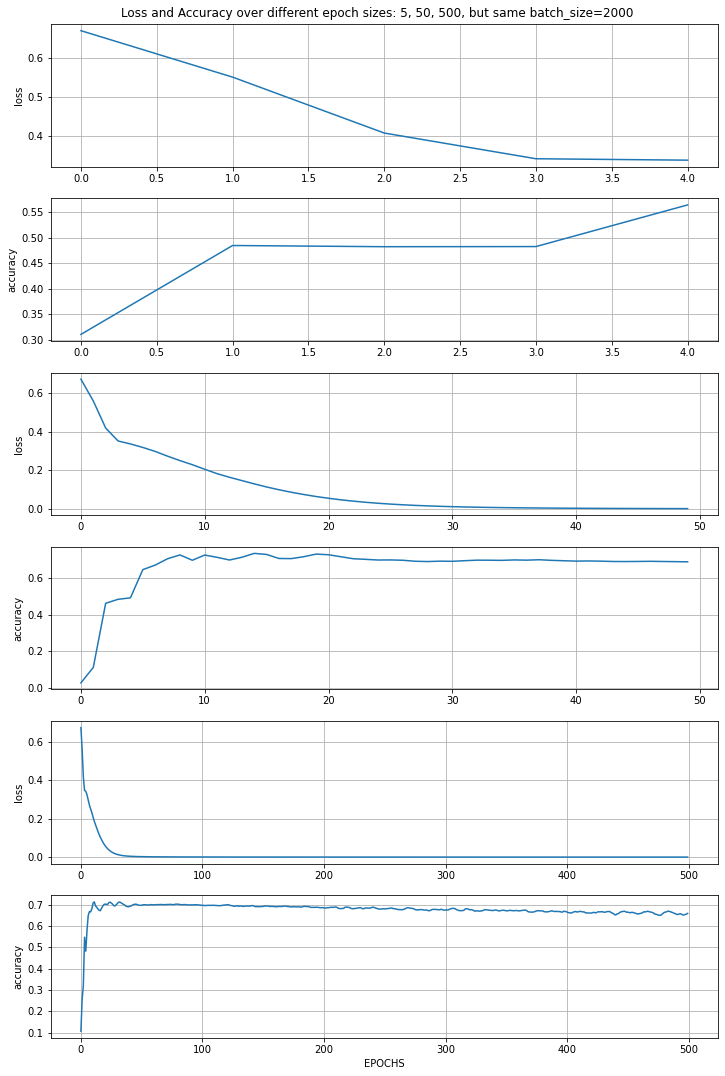

In [7]:
# Lets Plot the history, keys: "loss", "accuracy"
fig1, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1)
fig1.suptitle("Loss and Accuracy over different epoch sizes: 5, 50, 500, but same batch_size=2000")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history1.epoch, history1.history["loss"])
ax1.grid()

ax2.set_ylabel("accuracy")
ax2.plot(history1.epoch, history1.history["categorical_accuracy"])
ax2.grid()

ax3.set_ylabel("loss")
ax3.plot(history2.epoch, history2.history["loss"])
ax3.grid()

ax4.set_ylabel("accuracy")
ax4.plot(history2.epoch, history2.history["categorical_accuracy"])
ax4.grid()

ax5.set_ylabel("loss")
ax5.plot(history3.epoch, history3.history["loss"])
ax5.grid()

ax6.set_xlabel("EPOCHS")
ax6.set_ylabel("accuracy")
ax6.plot(history3.epoch, history3.history["categorical_accuracy"])
ax6.grid()
plt.show()

In [8]:
myNN4 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history4 = myNN4.fit(X_train, y_train, epochs=15, batch_size=1000, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
4/4 - 4s - loss: 0.6285 - categorical_accuracy: 0.3126
Epoch 2/15
4/4 - 3s - loss: 0.3979 - categorical_accuracy: 0.4823
Epoch 3/15
4/4 - 3s - loss: 0.3405 - categorical_accuracy: 0.5406
Epoch 4/15
4/4 - 3s - loss: 0.3008 - categorical_accuracy: 0.6189
Epoch 5/15
4/4 - 3s - loss: 0.2606 - categorical_accuracy: 0.6333
Epoch 6/15
4/4 - 3s - loss: 0.2247 - categorical_accuracy: 0.7061
Epoch 7/15
4/4 - 3s - loss: 0.1867 - categorical_accuracy: 0.7402
Epoch 8/15
4/4 - 3s - loss: 0.1547 - categorical_accuracy: 0.7054
Epoch 9/15
4/4 - 4s - loss: 0.1247 - categorical_accuracy: 0.7090
Epoch 10/15
4/4 - 4s - loss: 0.0989 - categorical_accuracy: 0.7022
Epoch 11/15
4/4 - 3s - loss: 0.0772 - categorical_accuracy: 0.7067
Epoch 12/15
4/4 - 3s - loss: 0.0594 - categorical_accuracy: 0.7225
Epoch 13/15
4/4 - 3s - loss: 0.0455 - categorical_accuracy: 0.7220
Epoch 14/15
4/4 - 3s - loss: 0.0348 - categorical_accuracy: 0.7134
Epoch 15/15


In [9]:
myNN5 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history5 = myNN5.fit(X_train, y_train, epochs=15, batch_size=1500, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
3/3 - 5s - loss: 0.6569 - categorical_accuracy: 0.1510
Epoch 2/15
3/3 - 4s - loss: 0.4657 - categorical_accuracy: 0.4828
Epoch 3/15
3/3 - 4s - loss: 0.3513 - categorical_accuracy: 0.4823
Epoch 4/15
3/3 - 4s - loss: 0.3336 - categorical_accuracy: 0.5515
Epoch 5/15
3/3 - 5s - loss: 0.2983 - categorical_accuracy: 0.6283
Epoch 6/15
3/3 - 5s - loss: 0.2673 - categorical_accuracy: 0.6182
Epoch 7/15
3/3 - 4s - loss: 0.2404 - categorical_accuracy: 0.6741
Epoch 8/15
3/3 - 4s - loss: 0.2073 - categorical_accuracy: 0.7470
Epoch 9/15
3/3 - 4s - loss: 0.1783 - categorical_accuracy: 0.7283
Epoch 10/15
3/3 - 4s - loss: 0.1538 - categorical_accuracy: 0.7061
Epoch 11/15
3/3 - 3s - loss: 0.1296 - categorical_accuracy: 0.7186
Epoch 12/15
3/3 - 3s - loss: 0.1082 - categorical_accuracy: 0.7233
Epoch 13/15
3/3 - 3s - loss: 0.0901 - categorical_accuracy: 0.7160
Epoch 14/15
3/3 - 6s - loss: 0.0740 - categorical_accuracy: 0.7113
Epoch 15/15


In [10]:
myNN6 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history6 = myNN6.fit(X_train, y_train, epochs=15, batch_size=1750, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
3/3 - 4s - loss: 0.6672 - categorical_accuracy: 0.0643
Epoch 2/15
3/3 - 3s - loss: 0.4868 - categorical_accuracy: 0.1340
Epoch 3/15
3/3 - 3s - loss: 0.3499 - categorical_accuracy: 0.5047
Epoch 4/15
3/3 - 4s - loss: 0.3428 - categorical_accuracy: 0.5632
Epoch 5/15
3/3 - 5s - loss: 0.3097 - categorical_accuracy: 0.6189
Epoch 6/15
3/3 - 5s - loss: 0.2750 - categorical_accuracy: 0.6900
Epoch 7/15
3/3 - 4s - loss: 0.2467 - categorical_accuracy: 0.7231
Epoch 8/15
3/3 - 3s - loss: 0.2180 - categorical_accuracy: 0.7251
Epoch 9/15
3/3 - 3s - loss: 0.1874 - categorical_accuracy: 0.7374
Epoch 10/15
3/3 - 3s - loss: 0.1628 - categorical_accuracy: 0.7228
Epoch 11/15
3/3 - 3s - loss: 0.1393 - categorical_accuracy: 0.7074
Epoch 12/15
3/3 - 3s - loss: 0.1173 - categorical_accuracy: 0.7142
Epoch 13/15
3/3 - 3s - loss: 0.0985 - categorical_accuracy: 0.7231
Epoch 14/15
3/3 - 4s - loss: 0.0821 - categorical_accuracy: 0.7369
Epoch 15/15


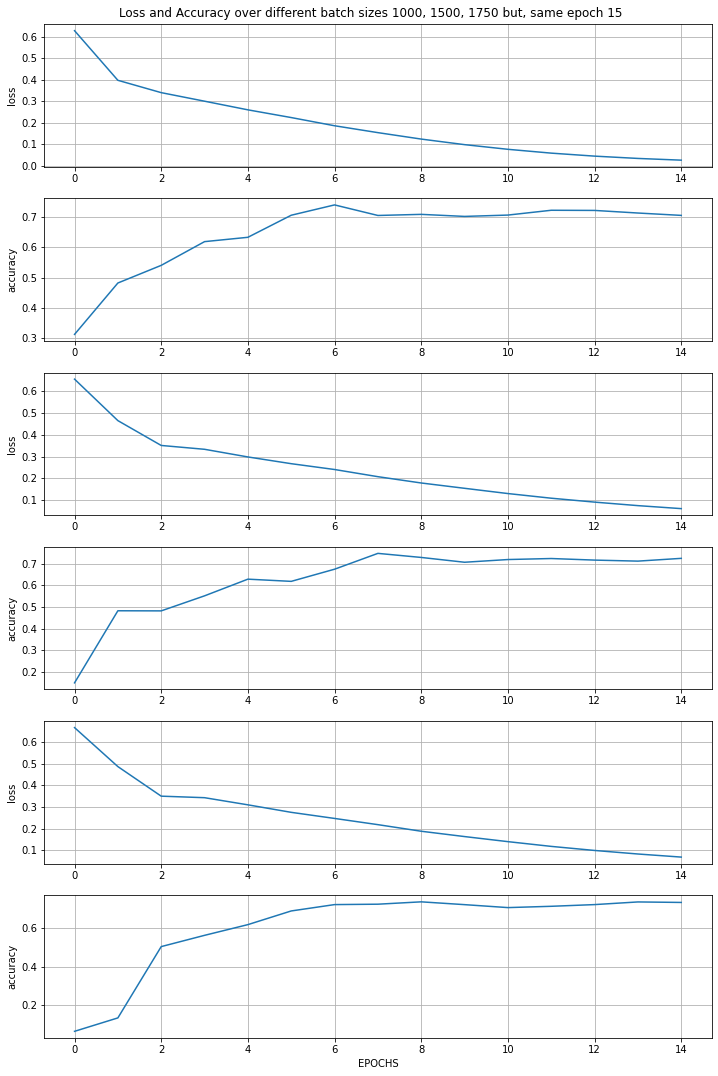

In [11]:
# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1)
fig1.suptitle("Loss and Accuracy over different batch sizes 1000, 1500, 1750 but, same epoch 15")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history4.epoch, history4.history["loss"])
ax1.grid()

ax2.set_ylabel("accuracy")
ax2.plot(history4.epoch, history4.history["categorical_accuracy"])
ax2.grid()

ax3.set_ylabel("loss")
ax3.plot(history5.epoch, history5.history["loss"])
ax3.grid()

ax4.set_ylabel("accuracy")
ax4.plot(history5.epoch, history5.history["categorical_accuracy"])
ax4.grid()

ax5.set_ylabel("loss")
ax5.plot(history6.epoch, history6.history["loss"])
ax5.grid()

ax6.set_xlabel("EPOCHS")
ax6.set_ylabel("accuracy")
ax6.plot(history6.epoch, history6.history["categorical_accuracy"])
ax6.grid()
plt.show()

In [12]:
myNN7 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history7 = myNN7.fit(X_train, y_train, epochs=15, batch_size=100, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
39/39 - 6s - loss: 0.3614 - categorical_accuracy: 0.4534
Epoch 2/15
39/39 - 6s - loss: 0.1776 - categorical_accuracy: 0.6054
Epoch 3/15
39/39 - 6s - loss: 0.0673 - categorical_accuracy: 0.6322
Epoch 4/15
39/39 - 5s - loss: 0.0208 - categorical_accuracy: 0.6359
Epoch 5/15
39/39 - 6s - loss: 0.0071 - categorical_accuracy: 0.6419
Epoch 6/15
39/39 - 6s - loss: 0.0033 - categorical_accuracy: 0.6476
Epoch 7/15
39/39 - 7s - loss: 0.0019 - categorical_accuracy: 0.6525
Epoch 8/15
39/39 - 6s - loss: 0.0013 - categorical_accuracy: 0.6694
Epoch 9/15
39/39 - 6s - loss: 9.5679e-04 - categorical_accuracy: 0.6627
Epoch 10/15
39/39 - 8s - loss: 7.5909e-04 - categorical_accuracy: 0.6676
Epoch 11/15
39/39 - 6s - loss: 6.3316e-04 - categorical_accuracy: 0.6817
Epoch 12/15
39/39 - 6s - loss: 5.5411e-04 - categorical_accuracy: 0.6741
Epoch 13/15
39/39 - 6s - loss: 4.6497e-04 - categorical_accuracy: 0.6632
Epoch 14/15
39/39 - 5s - loss: 4.

In [13]:
myNN8 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history8 = myNN8.fit(X_train, y_train, epochs=15, batch_size=250, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
16/16 - 5s - loss: 0.4345 - categorical_accuracy: 0.3766
Epoch 2/15
16/16 - 4s - loss: 0.2695 - categorical_accuracy: 0.6111
Epoch 3/15
16/16 - 4s - loss: 0.1723 - categorical_accuracy: 0.6317
Epoch 4/15
16/16 - 4s - loss: 0.0935 - categorical_accuracy: 0.6525
Epoch 5/15
16/16 - 4s - loss: 0.0451 - categorical_accuracy: 0.6583
Epoch 6/15
16/16 - 6s - loss: 0.0217 - categorical_accuracy: 0.6580
Epoch 7/15
16/16 - 4s - loss: 0.0113 - categorical_accuracy: 0.6598
Epoch 8/15
16/16 - 4s - loss: 0.0064 - categorical_accuracy: 0.6653
Epoch 9/15
16/16 - 4s - loss: 0.0042 - categorical_accuracy: 0.6760
Epoch 10/15
16/16 - 4s - loss: 0.0030 - categorical_accuracy: 0.6655
Epoch 11/15
16/16 - 4s - loss: 0.0022 - categorical_accuracy: 0.6801
Epoch 12/15
16/16 - 4s - loss: 0.0018 - categorical_accuracy: 0.6853
Epoch 13/15
16/16 - 4s - loss: 0.0014 - categorical_accuracy: 0.6926
Epoch 14/15
16/16 - 5s - loss: 0.0012 - categorical_a

In [14]:
myNN9 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history9 = myNN9.fit(X_train, y_train, epochs=15, batch_size=500, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
8/8 - 7s - loss: 0.5129 - categorical_accuracy: 0.3394
Epoch 2/15
8/8 - 4s - loss: 0.3323 - categorical_accuracy: 0.5263
Epoch 3/15
8/8 - 4s - loss: 0.2645 - categorical_accuracy: 0.5919
Epoch 4/15
8/8 - 6s - loss: 0.2007 - categorical_accuracy: 0.7038
Epoch 5/15
8/8 - 4s - loss: 0.1444 - categorical_accuracy: 0.6720
Epoch 6/15
8/8 - 4s - loss: 0.0992 - categorical_accuracy: 0.6700
Epoch 7/15
8/8 - 3s - loss: 0.0652 - categorical_accuracy: 0.6913
Epoch 8/15
8/8 - 3s - loss: 0.0420 - categorical_accuracy: 0.6864
Epoch 9/15
8/8 - 3s - loss: 0.0270 - categorical_accuracy: 0.7069
Epoch 10/15
8/8 - 3s - loss: 0.0177 - categorical_accuracy: 0.6957
Epoch 11/15
8/8 - 3s - loss: 0.0121 - categorical_accuracy: 0.6858
Epoch 12/15
8/8 - 4s - loss: 0.0085 - categorical_accuracy: 0.7108
Epoch 13/15
8/8 - 4s - loss: 0.0063 - categorical_accuracy: 0.7069
Epoch 14/15
8/8 - 4s - loss: 0.0048 - categorical_accuracy: 0.7004
Epoch 15/15


In [15]:
myNN10 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
history10 = myNN10.fit(X_train, y_train, epochs=15, batch_size=750, verbose=2)

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Epoch 1/15
6/6 - 4s - loss: 0.5849 - categorical_accuracy: 0.1450
Epoch 2/15
6/6 - 3s - loss: 0.3480 - categorical_accuracy: 0.4914
Epoch 3/15
6/6 - 3s - loss: 0.3029 - categorical_accuracy: 0.6346
Epoch 4/15
6/6 - 4s - loss: 0.2505 - categorical_accuracy: 0.7106
Epoch 5/15
6/6 - 5s - loss: 0.1986 - categorical_accuracy: 0.7116
Epoch 6/15
6/6 - 3s - loss: 0.1524 - categorical_accuracy: 0.6791
Epoch 7/15
6/6 - 3s - loss: 0.1143 - categorical_accuracy: 0.6861
Epoch 8/15
6/6 - 3s - loss: 0.0833 - categorical_accuracy: 0.6895
Epoch 9/15
6/6 - 3s - loss: 0.0599 - categorical_accuracy: 0.6897
Epoch 10/15
6/6 - 3s - loss: 0.0429 - categorical_accuracy: 0.7012
Epoch 11/15
6/6 - 3s - loss: 0.0308 - categorical_accuracy: 0.7067
Epoch 12/15
6/6 - 3s - loss: 0.0222 - categorical_accuracy: 0.7002
Epoch 13/15
6/6 - 3s - loss: 0.0165 - categorical_accuracy: 0.6903
Epoch 14/15
6/6 - 3s - loss: 0.0124 - categorical_accuracy: 0.7160
Epoch 15/15


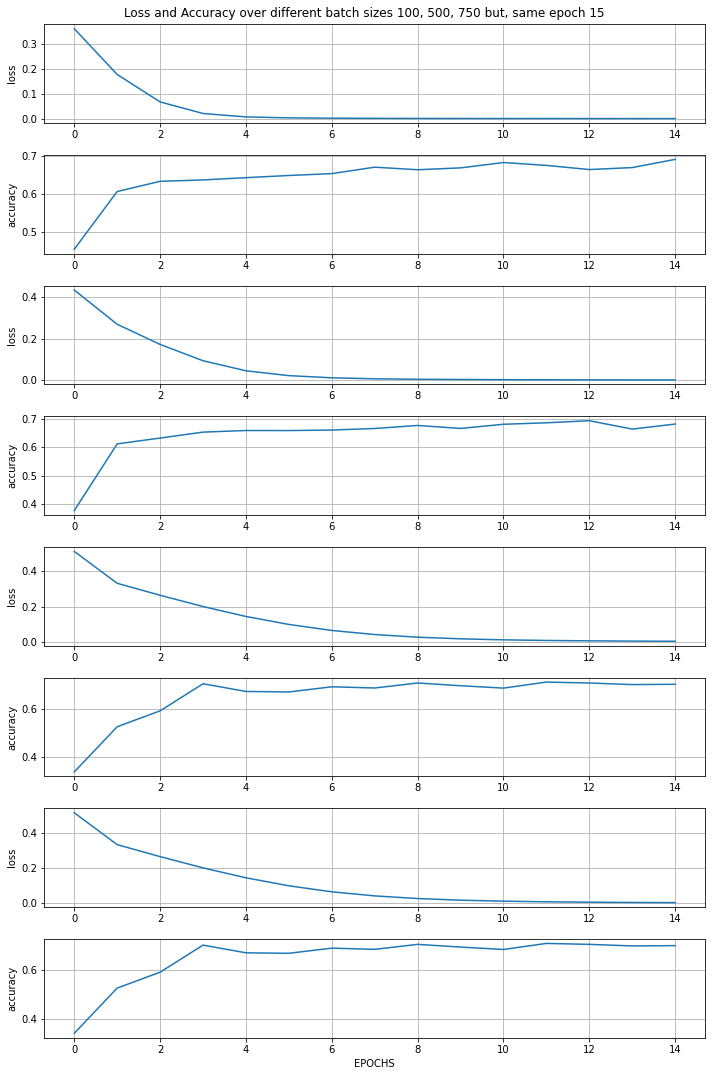

In [16]:
# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8,1)
fig1.suptitle("Loss and Accuracy over different batch sizes 100, 500, 750 but, same epoch 15")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history7.epoch, history7.history["loss"])
ax1.grid()

ax2.set_ylabel("accuracy")
ax2.plot(history7.epoch, history7.history["categorical_accuracy"])
ax2.grid()

ax3.set_ylabel("loss")
ax3.plot(history8.epoch, history8.history["loss"])
ax3.grid()

ax4.set_ylabel("accuracy")
ax4.plot(history8.epoch, history8.history["categorical_accuracy"])
ax4.grid()

ax5.set_ylabel("loss")
ax5.plot(history9.epoch, history9.history["loss"])
ax5.grid()

ax6.set_ylabel("accuracy")
ax6.plot(history9.epoch, history9.history["categorical_accuracy"])
ax6.grid()

ax7.set_ylabel("loss")
ax7.plot(history9.epoch, history9.history["loss"])
ax7.grid()

ax8.set_xlabel("EPOCHS")
ax8.set_ylabel("accuracy")
ax8.plot(history9.epoch, history9.history["categorical_accuracy"])
ax8.grid()
plt.show()

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 1000)              23663000  
_________________________________________________________________
dense_37 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_38 (Dense)             (None, 21)                10521     
Total params: 24,174,021
Trainable params: 24,174,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1/1 - 5s - loss: 0.6878 - categorical_accuracy: 0.1812
Epoch 2/15
1/1 - 2s - loss: 0.6295 - categorical_accuracy: 0.4878
Epoch 3/15
1/1 - 2s - loss: 0.5596 - categorical_accuracy: 0.4841
Epoch 4/15
1/1 - 2s - loss: 0.4773 - categorical_accuracy: 0.4831
Epoch 5/15
1/1 - 2s - loss: 0.4005 - categorical

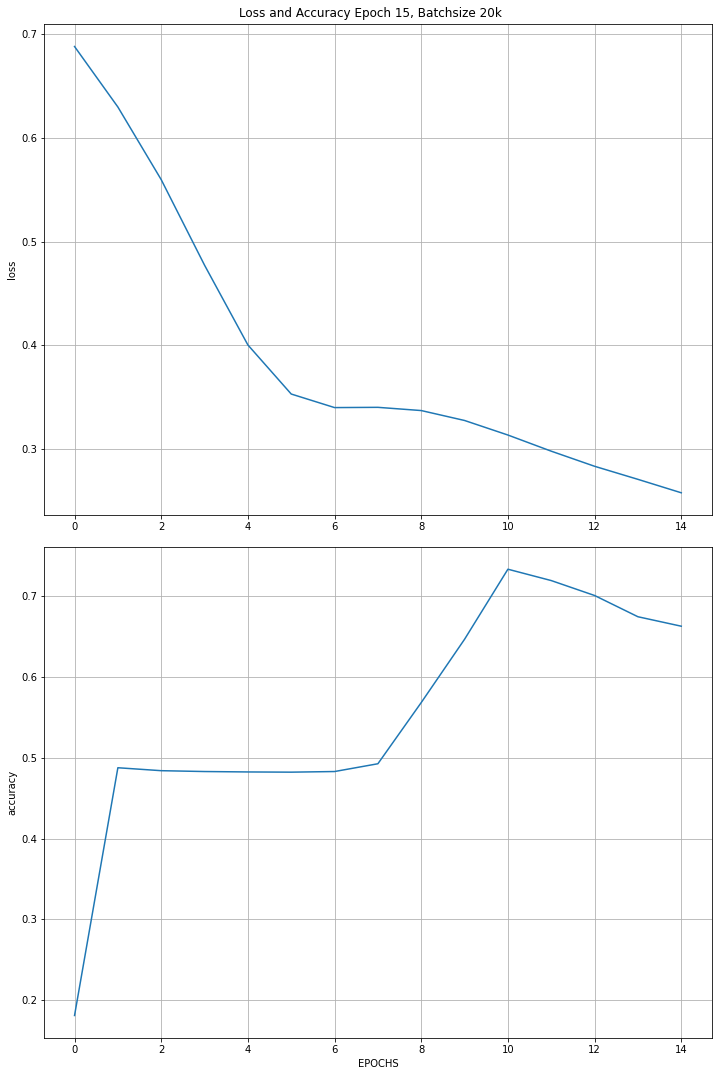

In [19]:
# Before we move on let's try a super large batch size
myNN11 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN11.summary()
history11 = myNN11.fit(X_train, y_train, epochs=15, batch_size=20000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 20k")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history11.epoch, history11.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history11.epoch, history11.history["categorical_accuracy"])
ax2.grid()
plt.show()



Hidden Layer: 1 Size of: 1000
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 1000)              23663000  
_________________________________________________________________
dense_42 (Dense)             (None, 21)                21021     
Total params: 23,684,021
Trainable params: 23,684,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2/2 - 4s - loss: 0.6732 - categorical_accuracy: 0.2015
Epoch 2/15
2/2 - 3s - loss: 0.5752 - categorical_accuracy: 0.5612
Epoch 3/15
2/2 - 3s - loss: 0.4777 - categorical_accuracy: 0.5976
Epoch 4/15
2/2 - 3s - loss: 0.3962 - categorical_accuracy: 0.5435
Epoch 5/15
2/2 - 3s - loss: 0.3431 - categorical_accuracy: 0.5245
Epoch 6/15
2/2 - 3s - loss: 0.3125 - categorical_accuracy: 0.5690
Epoch 7/15
2/2 - 3s - loss: 0.2921 - categorical_accuracy: 0.6658
Epoch 8/15


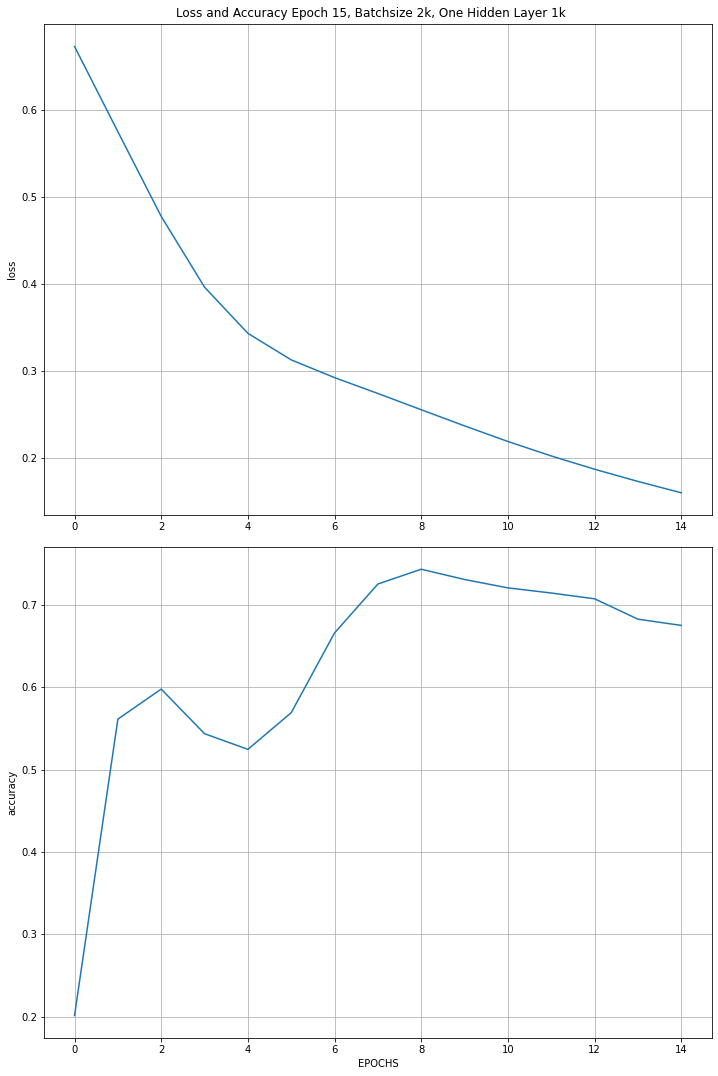

In [21]:
# Okay, by now its clear that batch size and the number of epochs affect accuracy and loss.
# Now let's see how adjusting the hiddel layers and number of nodes affects accuracy and loss.

h_nodes = [1000] # one hidden layers
myNN12 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN12.summary()
history12 = myNN12.fit(X_train, y_train, epochs=15, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 2k, One Hidden Layer 1k")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history12.epoch, history12.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history12.epoch, history12.history["categorical_accuracy"])
ax2.grid()
plt.show()






Hidden Layer: 1 Size of: 100
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 100)               2366300   
_________________________________________________________________
dense_44 (Dense)             (None, 21)                2121      
Total params: 2,368,421
Trainable params: 2,368,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2/2 - 1s - loss: 0.6889 - categorical_accuracy: 0.0367
Epoch 2/15
2/2 - 0s - loss: 0.6603 - categorical_accuracy: 0.1054
Epoch 3/15
2/2 - 0s - loss: 0.6306 - categorical_accuracy: 0.1327
Epoch 4/15
2/2 - 1s - loss: 0.5987 - categorical_accuracy: 0.1494
Epoch 5/15
2/2 - 0s - loss: 0.5657 - categorical_accuracy: 0.1655
Epoch 6/15
2/2 - 0s - loss: 0.5324 - categorical_accuracy: 0.1861
Epoch 7/15
2/2 - 0s - loss: 0.4995 - categorical_accuracy: 0.2317
Epoch 8/15
2/2

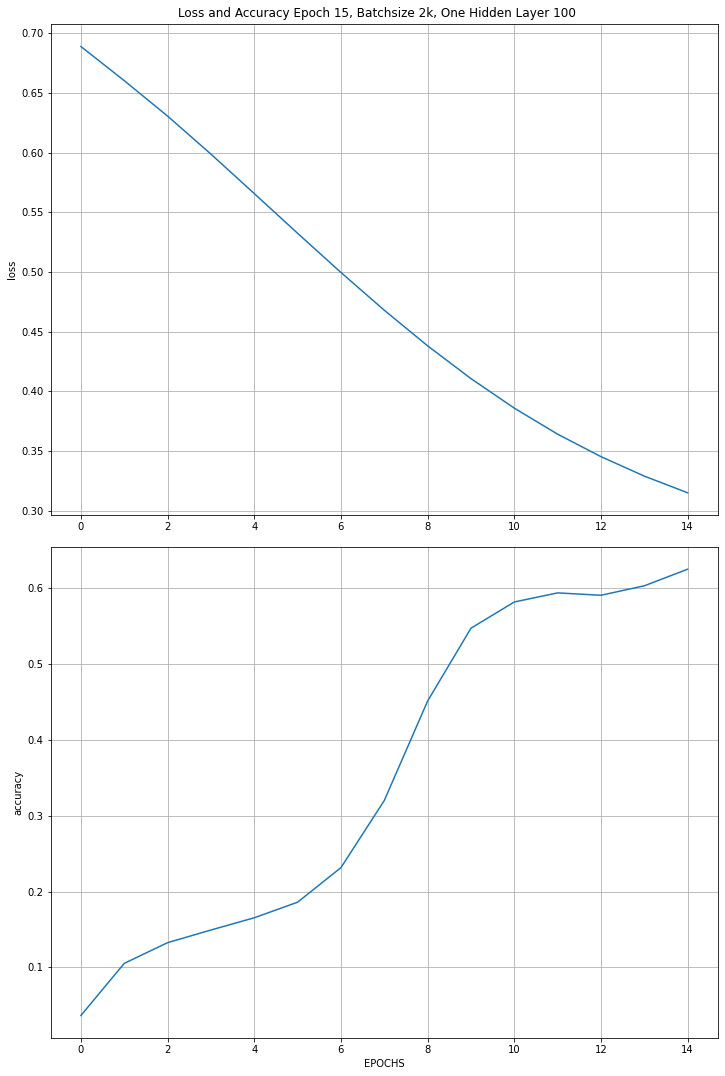

In [22]:
h_nodes = [100] # one hidden layers
myNN13 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN13.summary()
history13 = myNN13.fit(X_train, y_train, epochs=15, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 2k, One Hidden Layer 100")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history13.epoch, history13.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history13.epoch, history13.history["categorical_accuracy"])
ax2.grid()
plt.show()

Hidden Layer: 1 Size of: 10
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 10)                236630    
_________________________________________________________________
dense_50 (Dense)             (None, 21)                231       
Total params: 236,861
Trainable params: 236,861
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2/2 - 1s - loss: 0.6924 - categorical_accuracy: 0.0310
Epoch 2/15
2/2 - 0s - loss: 0.6872 - categorical_accuracy: 0.0416
Epoch 3/15
2/2 - 0s - loss: 0.6823 - categorical_accuracy: 0.0349
Epoch 4/15
2/2 - 0s - loss: 0.6772 - categorical_accuracy: 0.0289
Epoch 5/15
2/2 - 0s - loss: 0.6718 - categorical_accuracy: 0.0242
Epoch 6/15
2/2 - 0s - loss: 0.6662 - categorical_accuracy: 0.0219
Epoch 7/15
2/2 - 0s - loss: 0.6604 - categorical_accuracy: 0.0193
Epoch 8/15
2/2 - 0s

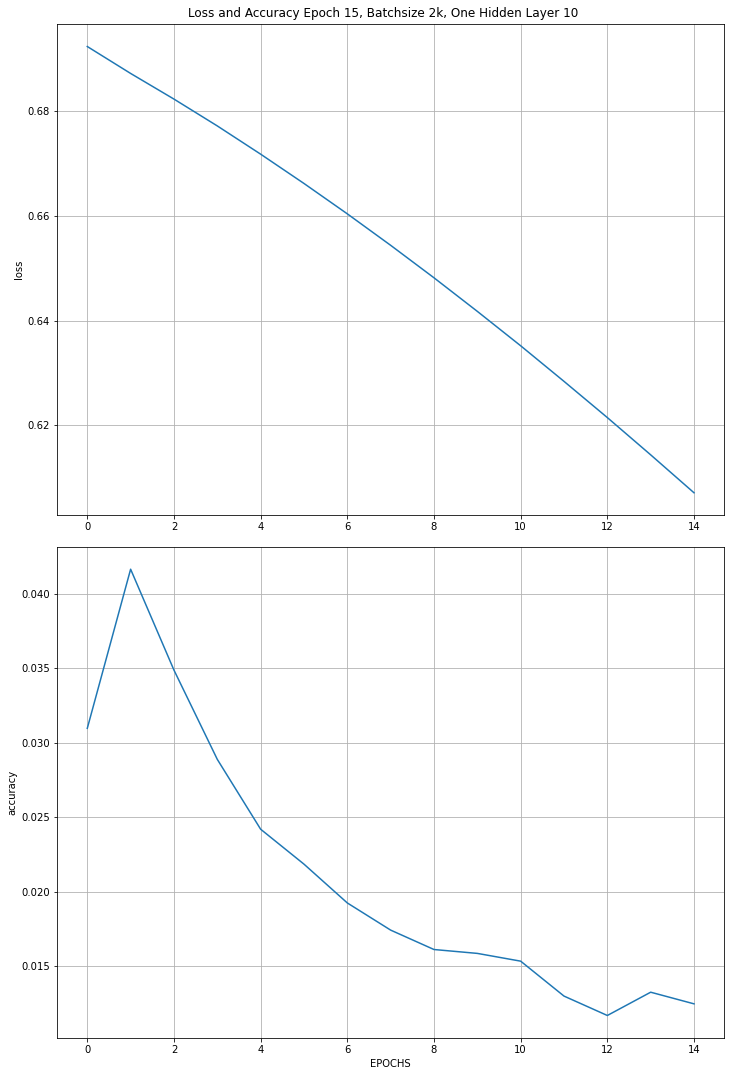

In [25]:
h_nodes = [10] # one hidden layers
myNN14 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN14.summary()
history14 = myNN14.fit(X_train, y_train, epochs=15, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 2k, One Hidden Layer 10")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history14.epoch, history14.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history14.epoch, history14.history["categorical_accuracy"])
ax2.grid()
plt.show()

Hidden Layer: 1 Size of: 1
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 1)                 23663     
_________________________________________________________________
dense_52 (Dense)             (None, 21)                42        
Total params: 23,705
Trainable params: 23,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2/2 - 1s - loss: 0.6928 - categorical_accuracy: 0.0898
Epoch 2/15
2/2 - 0s - loss: 0.6916 - categorical_accuracy: 0.1044
Epoch 3/15
2/2 - 0s - loss: 0.6903 - categorical_accuracy: 0.0328
Epoch 4/15
2/2 - 0s - loss: 0.6890 - categorical_accuracy: 0.0099
Epoch 5/15
2/2 - 0s - loss: 0.6876 - categorical_accuracy: 0.0055
Epoch 6/15
2/2 - 0s - loss: 0.6863 - categorical_accuracy: 0.0042
Epoch 7/15
2/2 - 0s - loss: 0.6849 - categorical_accuracy: 0.0029
Epoch 8/15
2/2 - 0s - 

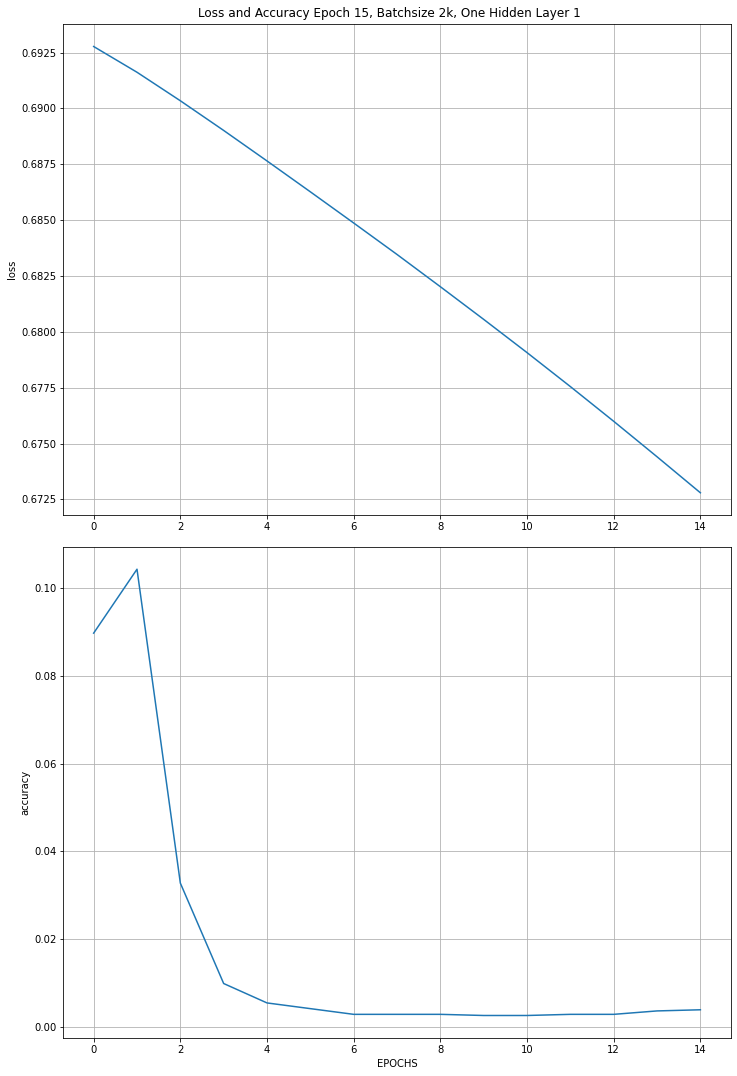

In [26]:
h_nodes = [1] # one hidden layers
myNN15 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN15.summary()
history15 = myNN15.fit(X_train, y_train, epochs=15, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 2k, One Hidden Layer 1")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history15.epoch, history15.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history15.epoch, history15.history["categorical_accuracy"])
ax2.grid()
plt.show()

Hidden Layer: 1 Size of: 10000
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 10000)             236630000 
_________________________________________________________________
dense_56 (Dense)             (None, 21)                210021    
Total params: 236,840,021
Trainable params: 236,840,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2/2 - 28s - loss: 0.6196 - categorical_accuracy: 0.2496
Epoch 2/15
2/2 - 30s - loss: 0.3886 - categorical_accuracy: 0.4826
Epoch 3/15
2/2 - 28s - loss: 0.3225 - categorical_accuracy: 0.5151
Epoch 4/15
2/2 - 32s - loss: 0.2975 - categorical_accuracy: 0.6655
Epoch 5/15
2/2 - 28s - loss: 0.2636 - categorical_accuracy: 0.6923
Epoch 6/15
2/2 - 29s - loss: 0.2285 - categorical_accuracy: 0.6439
Epoch 7/15
2/2 - 28s - loss: 0.1981 - categorical_accuracy: 0.6106
E

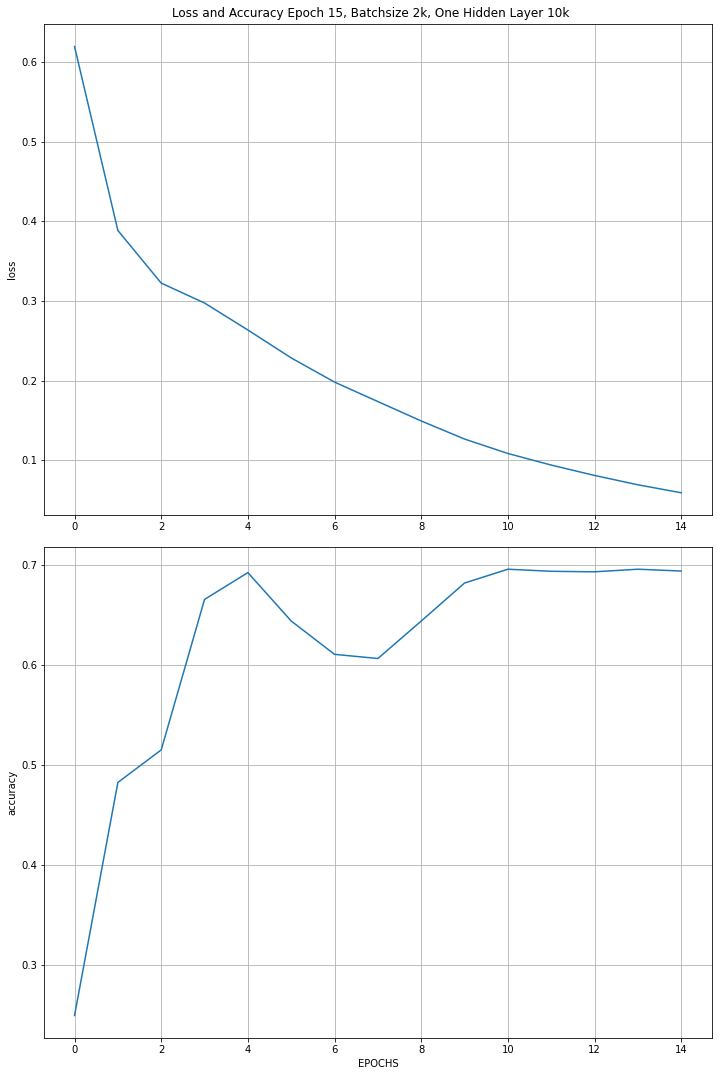

In [28]:
#  Well, what if we increase the the number of nodes using one layer
h_nodes = [10000] # one hidden layers
myNN16 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN16.summary()
history16 = myNN16.fit(X_train, y_train, epochs=15, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 2k, One Hidden Layer 10k")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history16.epoch, history16.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history16.epoch, history16.history["categorical_accuracy"])
ax2.grid()
plt.show()

Hidden Layer: 1 Size of: 5000
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 5000)              118315000 
_________________________________________________________________
dense_58 (Dense)             (None, 21)                105021    
Total params: 118,420,021
Trainable params: 118,420,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2/2 - 13s - loss: 0.6469 - categorical_accuracy: 0.2285
Epoch 2/15
2/2 - 14s - loss: 0.4517 - categorical_accuracy: 0.5055
Epoch 3/15
2/2 - 16s - loss: 0.3442 - categorical_accuracy: 0.4839
Epoch 4/15
2/2 - 17s - loss: 0.3110 - categorical_accuracy: 0.5817
Epoch 5/15
2/2 - 17s - loss: 0.2875 - categorical_accuracy: 0.6903
Epoch 6/15
2/2 - 15s - loss: 0.2588 - categorical_accuracy: 0.7236
Epoch 7/15
2/2 - 16s - loss: 0.2288 - categorical_accuracy: 0.6804
Ep

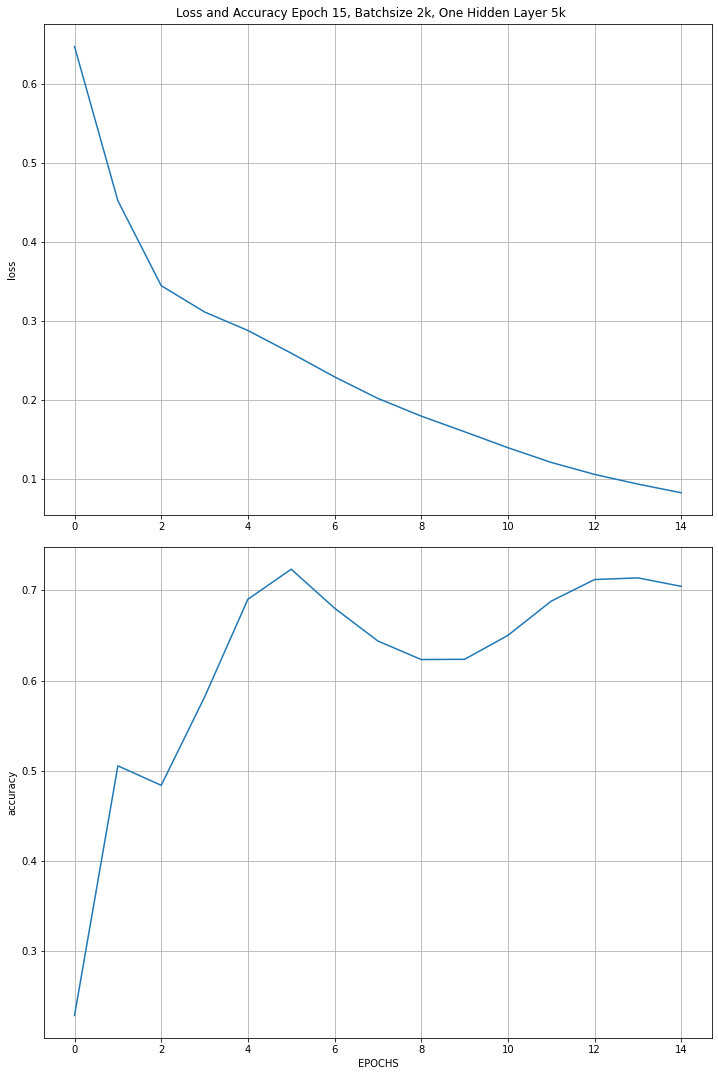

In [29]:
h_nodes = [5000] # one hidden layers
myNN17 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN17.summary()
history17 = myNN17.fit(X_train, y_train, epochs=15, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 15, Batchsize 2k, One Hidden Layer 5k")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history17.epoch, history17.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history17.epoch, history17.history["categorical_accuracy"])
ax2.grid()
plt.show()

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 1000
Hidden Layer: 3 Size of: 1000
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 1000)              23663000  
_________________________________________________________________
dense_90 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_91 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_92 (Dense)             (None, 21)                21021     
Total params: 25,686,021
Trainable params: 25,686,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 - 4s - loss: 0.6611 - categorical_accuracy: 0.1468
Epoch 2/20
2/2 - 3s - loss: 0.4594 - categorical_accuracy: 0.3995
Epoch 3/20
2/2 - 

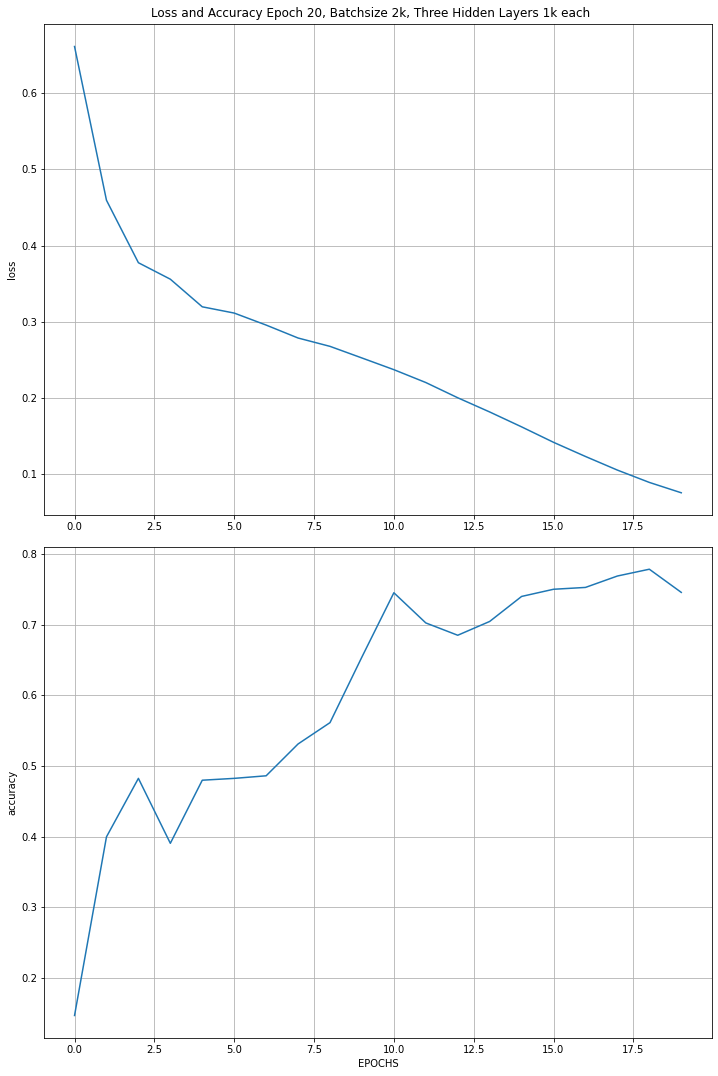

In [41]:
# Okay, now let's try increasing the number of hidden layers.
h_nodes = [1000, 1000, 1000] # three hidden layers
myNN18 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN18.summary()
history18 = myNN18.fit(X_train, y_train, epochs=20, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 20, Batchsize 2k, Three Hidden Layers 1k each")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history18.epoch, history18.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history18.epoch, history18.history["categorical_accuracy"])
ax2.grid()
plt.show()


Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Hidden Layer: 3 Size of: 250
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 1000)              23663000  
_________________________________________________________________
dense_86 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_87 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_88 (Dense)             (None, 21)                5271      
Total params: 24,294,021
Trainable params: 24,294,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 - 4s - loss: 0.6802 - categorical_accuracy: 0.2103
Epoch 2/20
2/2 - 3s - loss: 0.5881 - categorical_accuracy: 0.4828
Epoch 3/20
2/2 - 3s

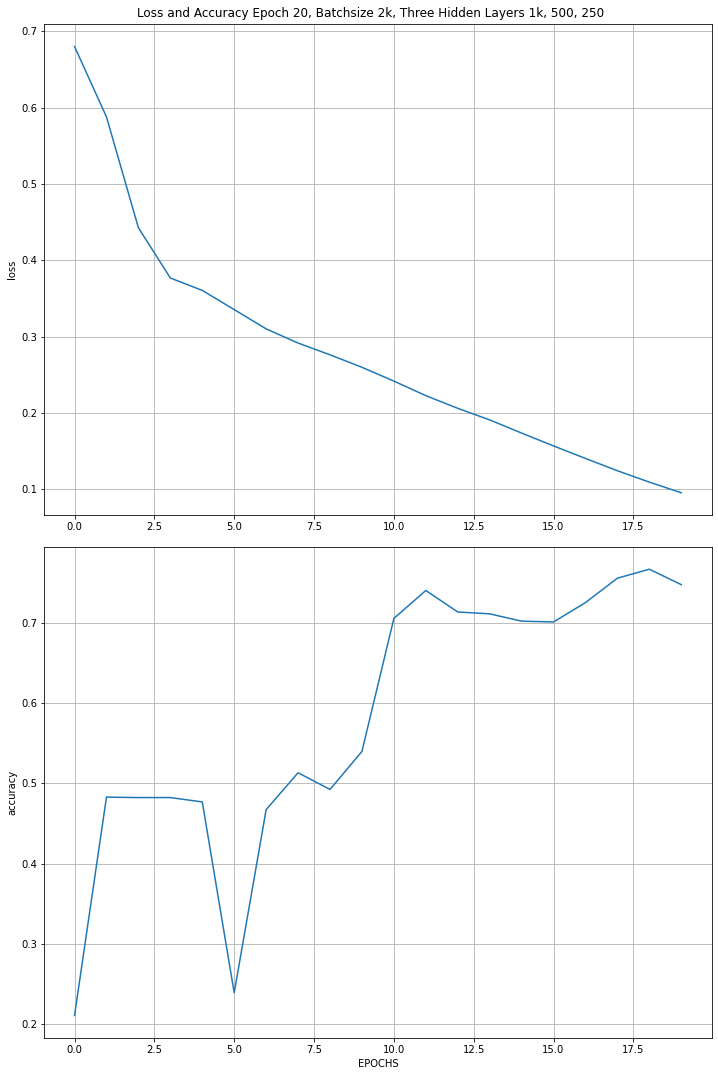

In [40]:
h_nodes = [1000, 500, 250] # three hidden layers
myNN19 = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN19.summary()
history19 = myNN19.fit(X_train, y_train, epochs=20, batch_size=2000, verbose=2)

# Lets Plot the history, keys: "loss", "accuracy" again
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle("Loss and Accuracy Epoch 20, Batchsize 2k, Three Hidden Layers 1k, 500, 250")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history19.epoch, history19.history["loss"])
ax1.grid()

ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("accuracy")
ax2.plot(history19.epoch, history19.history["categorical_accuracy"])
ax2.grid()
plt.show()

In [64]:
# Let's see how all these different models prediction results

print("Prediction results using myNN")
preds = myNN.predict(X_test)
print("preds raw values:", preds[0])
preds[preds>=0.5] = 1
preds[preds<0.5] = 0
print("preds 1/0 values:", preds[0])

print("\n\nPrediction results using myNN2")
preds2 = myNN2.predict(X_test)
print("preds raw values:", preds2[0])
preds2[preds2>=0.5] = 1
preds2[preds2<0.5] = 0
print("preds 1/0 values:", preds2[0])

print("\n\nPrediction results using myNN3")
preds3 = myNN3.predict(X_test)
print("preds raw values:", preds3[0])
preds3[preds3>=0.5] = 1
preds3[preds3<0.5] = 0
print("preds 1/0 values:", preds3[0])


Prediction results using myNN
preds raw values: [3.0031800e-04 5.6858128e-01 3.5424268e-01 2.0916942e-01 2.0284730e-01
 5.8614552e-02 2.3183584e-02 2.4943501e-02 7.2938204e-03 5.4443479e-03
 7.5482726e-03 2.8351247e-03 1.0681152e-03 1.2123287e-03 3.8453937e-04
 6.3428283e-04 4.3758750e-04 1.6161799e-04 1.8063188e-04 6.6766741e-05
 1.6981363e-04]
preds 1/0 values: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Prediction results using myNN2
preds raw values: [2.6800311e-15 9.9980915e-01 1.3095725e-08 9.9624676e-01 7.4238813e-01
 3.2184803e-07 4.1586944e-08 8.5538626e-04 2.6164900e-08 1.5617459e-08
 1.3767684e-10 4.9658146e-11 8.4255862e-06 7.7748336e-11 4.7746125e-05
 6.8333932e-08 2.3397957e-05 8.0675846e-08 2.2295453e-06 2.0911267e-08
 3.6525050e-09]
preds 1/0 values: [0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Prediction results using myNN3
preds raw values: [8.53978612e-25 1.00000000e+00 3.12995276e-15 9.99997735e-01
 6.11521065e-01 9.78481